# K-컬쳐 관광 트렌드 분석 및 콘텐츠 투어리즘 촉진 방안 제언

---

## 1. 데이터 로딩

In [1]:
import cudf as cd
import pandas as pd
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
foreign_cf = cd.read_csv('2023 외래관광객조사 DATA.csv', index_col=0)
foreign_cf

,pnid,MVIT,RVIT,XRVIT,TYP,Q1,Q1_1a1,Q1_1a2,Q1_1a3,Q2a1,...,Q14,D_MON,D_BUN,D_NAT,D_SEX,D_AGE,D_MOK,D_NUM,D_GUB,weight
0,6,4,4,5.0,1,1,2.0,3.0,4.0,4.0,...,5,1,1,3,2,2,1,4,1,866.099893
1,7,20,4,5.0,1,2,2.0,9.0,7.0,<NA>,...,5,1,1,1,1,3,2,4,1,191.333757
2,8,2,2,5.0,1,5,<NA>,<NA>,<NA>,<NA>,...,5,1,1,4,2,1,5,2,1,244.838755
3,10,1,1,<NA>,1,3,<NA>,<NA>,<NA>,<NA>,...,4,1,1,5,1,5,3,1,1,555.272342
4,11,3,3,5.0,1,2,8.0,3.0,7.0,<NA>,...,5,1,1,1,2,4,2,3,1,193.434506
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16191,21570,1,1,<NA>,1,1,1.0,9.0,8.0,5.0,...,4,12,4,1,1,4,1,1,1,1205.023267
16192,21571,1,1,<NA>,1,1,5.0,<NA>,<NA>,<NA>,...,5,12,4,1,1,3,1,1,1,1160.261837
16193,21572,3,3,5.0,1,2,4.0,6.0,2.0,<NA>,...,4,12,4,1,2,3,2,3,1,1403.603404
16194,21573,2,2,5.0,1,1,5.0,9.0,4.0,1.0,...,4,12,4,1,2,4,1,2,1,1220.901706


---

## 2. 분석 배경

- 전 세계적으로 **K-콘텐츠**가 인기를 얻고 있음.
    - 펜데믹 이후 K-POP 소비량이 전 세계적으로 약 2.5배 증가하였으며, 음반 수출액도 역대 최고치 경신함.
    - 단순히 대중음악을 의미하는 것이 아니라, 뷰티, 패션, 댄스 등을 아우르는 하나의 문화로 자리잡고 있음.
<br><br>
- K-콘텐츠를 접한 외국인이 한국을 방문하고자 하는 경우가 많음.
    - 호텔, 여행, 마이스업 등 다양한 영역의 관광산업에서 콘텐츠와 관광의 연계 활발함.
<br><br>
- 대한민국에도 **콘텐츠 투어리즘**에 대한 수요가 급증하고 있는데, 현재 한국에서의 콘텐츠 투어리즘이 관광 경험에 **긍정적 영향**을 주고 있는지 점검 필요함.
<br><br>
- **콘텐츠 투어리즘을 촉진**할 수 있는 아이디어를 제시하여, 대한민국 국가 브랜드 제고 및 관광 만족도 향상을 도모하고자 함.

---

## 3. 콘텐츠 투어리즘과 관광 경험 분석

In [3]:
# 파생 컬럼
foreign_cf['revisit'] = foreign_cf['XRVIT'].notna()

columns_Q1 = [col for col in foreign_cf.columns if col.startswith('Q1_1a')]
foreign_cf['motive_k-culture'] = foreign_cf[columns_Q1].applymap(lambda x: x == 7).fillna(False).any(axis=1)

columns_to_select = [col for col in foreign_cf.columns if col.startswith('Q2a')]
foreign_cf['only_korea'] = foreign_cf['Q2a_dk'].notna()

columns_Q3 = [col for col in foreign_cf.columns if col.startswith('Q3_1a')]
foreign_cf['plan_k-culture'] = foreign_cf[columns_Q3].applymap(lambda x: x == 7).fillna(False).any(axis=1)

columns_Q8 = [col for col in foreign_cf.columns if col.startswith('Q8a')]
foreign_cf['did_k-culture'] = foreign_cf['Q8a07'].notna()

columns_Q81 = [col for col in foreign_cf.columns if col.startswith('Q8_1a')]
foreign_cf['happy_k-culture'] = foreign_cf[columns_Q81].applymap(lambda x: x == 7).fillna(False).any(axis=1)

foreign_cf['shopping_goods'] = foreign_cf['쇼핑비1인대체'] * foreign_cf['MQ10_2b11'].fillna(0) / 100

columns_Q12 = [col for col in foreign_cf.columns if col.startswith('Q12a')]

- **콘텐츠 투어리즘** 요인과 **긍정적 관광 경험**의 관계를 분석하고자 함.
<br><br>
- 관광 경험의 **긍정적 수준**을 평가할 **지표**를 다음과 같이 정의함.
    - 국가 브랜드에 대한 충성도
    - 대한민국 관광 만족도

### 3-1. ‘K-콘텐츠 관심도’에 따른 ‘국가 브랜드에 대한 충성도’ 동향 분석

- **국가 브랜드에 대한 충성도**를 나타내는 **지표 정의**
    - 오직 한국만을 방문 후보지로 고려했는지 여부
    - 한국 재방문인지 여부

In [4]:
plan_kculture = foreign_cf[(foreign_cf['motive_k-culture'] == True) & (foreign_cf['plan_k-culture'] == True)]
no_plan_kculture = foreign_cf[(foreign_cf['motive_k-culture'] == True) & (foreign_cf['plan_k-culture'] == False)]

plan_kculture.shape, no_plan_kculture.shape

((1369, 372), (2242, 372))

- 대한민국을 방문한 외국인 관광객을 **K-콘텐츠 관심도**에 따라 **분할**
    - 집단 1: 대한민국 관광에 관심을 가지게 된 계기가 K-콘텐츠인 관광객
    - 집단 2: 대한민국 관광에 관심을 가지게 된 계기가 K-콘텐츠이면서, 한국여행 시 K-콘텐츠 활동을 고려한 관광객
<br><br>
- 가설 설정
    - 집단 1보다 집단 2의 ‘국가 브랜드에 대한 충성도’가 더 높을 것이다.

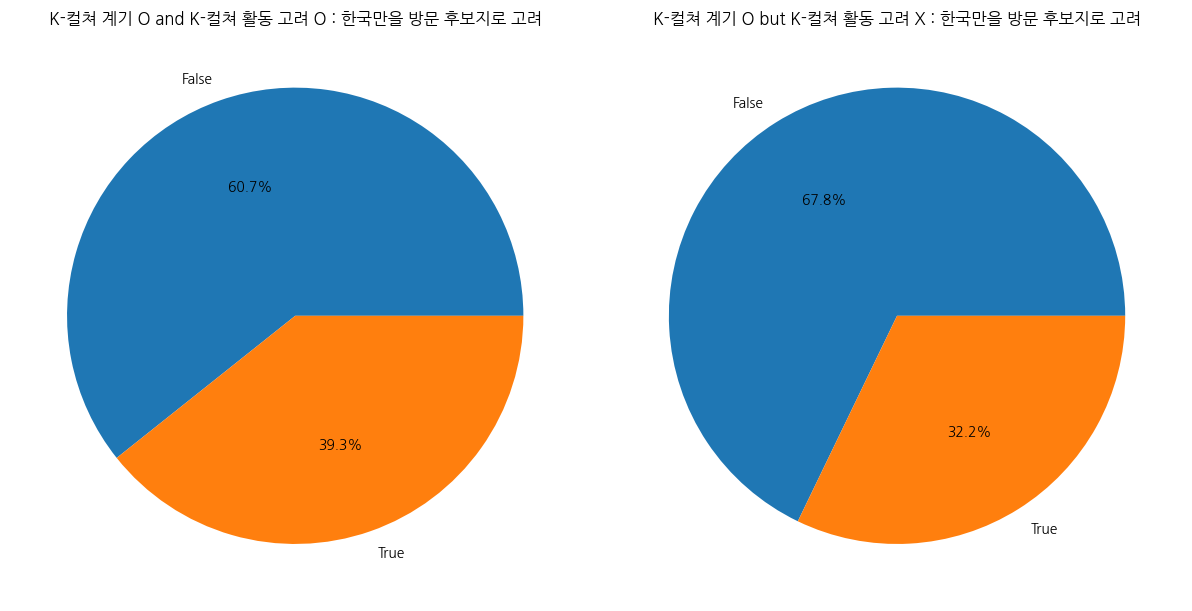

In [5]:
_, axes = plt.subplots(ncols=2, figsize=(12, 6), constrained_layout=True)

axes[0].pie(
    plan_kculture['only_korea'].value_counts().to_frame().sort_index()['count'].to_numpy(),
    autopct='%.1f%%',
    labels=plan_kculture['only_korea'].value_counts().to_frame().sort_index()['count'].index.to_arrow()
)
axes[0].set_title('K-컬쳐 계기 O and K-컬쳐 활동 고려 O : 한국만을 방문 후보지로 고려')

axes[1].pie(
    no_plan_kculture['only_korea'].value_counts().to_frame().sort_index()['count'].to_numpy(),
    autopct='%.1f%%',
    labels=no_plan_kculture['only_korea'].value_counts().to_frame().sort_index()['count'].index.to_arrow()
)
axes[1].set_title('K-컬쳐 계기 O but K-컬쳐 활동 고려 X : 한국만을 방문 후보지로 고려')

plt.show()

In [6]:
_, p, _, _ = stats.chi2_contingency([
    plan_kculture['only_korea'].value_counts().reindex([True, False], fill_value=0).to_numpy(),
    no_plan_kculture['only_korea'].value_counts().reindex([True, False], fill_value=0).to_numpy()
])

alpha = 0.05
if p < alpha:
    print("K-컬쳐 활동 고려 여부와 한국만을 방문 후보지로 고려 여부는 독립적이지 않음.")
else:
    print("K-컬쳐 활동 고려 여부와 한국만을 방문 후보지로 고려 여부는 독립적임.")

K-컬쳐 활동 고려 여부와 한국만을 방문 후보지로 고려 여부는 독립적이지 않음.


- 한국여행 관심 계기에 K-컬쳐가 포함되어 있지만 K-컬쳐 활동을 고려하지 않은 관광객들은 한국만을 방문 후보지로 고려한 비율이 비교적 낮음.
- 카이제곱 독립성 검정 결과, K-컬쳐 활동 고려 여부가 한국만을 방문 후보지로 고려 여부에 영향을 주는 것으로 판단할 수 있음.
- 즉, K-컬쳐 활동을 고려한 관광객들이 비교적 **국가 브랜드에 대한 충성도**가 높은 것으로 이해할 수 있음.

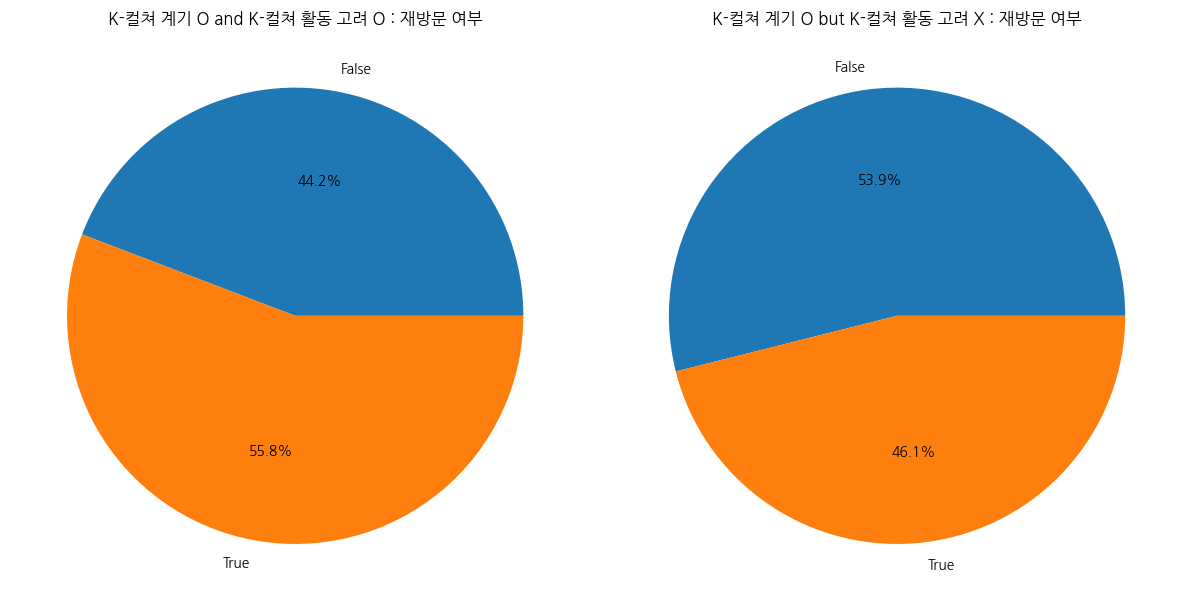

In [7]:
_, axes = plt.subplots(ncols=2, figsize=(12, 6), constrained_layout=True)

axes[0].pie(
    plan_kculture['revisit'].value_counts().to_frame().sort_index()['count'].to_numpy(),
    autopct='%.1f%%',
    labels=plan_kculture['revisit'].value_counts().to_frame().sort_index()['count'].index.to_arrow()
)
axes[0].set_title('K-컬쳐 계기 O and K-컬쳐 활동 고려 O : 재방문 여부')

axes[1].pie(
    no_plan_kculture['revisit'].value_counts().to_frame().sort_index()['count'].to_numpy(),
    autopct='%.1f%%',
    labels=no_plan_kculture['revisit'].value_counts().to_frame().sort_index()['count'].index.to_arrow()
)
axes[1].set_title('K-컬쳐 계기 O but K-컬쳐 활동 고려 X : 재방문 여부')

plt.show()

In [8]:
_, p, _, _ = stats.chi2_contingency([
    plan_kculture['revisit'].value_counts().reindex([True, False], fill_value=0).to_numpy(),
    no_plan_kculture['revisit'].value_counts().reindex([True, False], fill_value=0).to_numpy()
])

alpha = 0.05
if p < alpha:
    print("K-컬쳐 활동 고려 여부와 재방문 여부는 독립적이지 않음.")
else:
    print("K-컬쳐 활동 고려 여부와 재방문 여부는 독립적임.")

K-컬쳐 활동 고려 여부와 재방문 여부는 독립적이지 않음.


- 한국여행 관심 계기에 K-컬쳐가 포함되어 있지만 K-컬쳐 활동을 고려하지 않은 관광객들은 한국에 첫 방문인 경우가 많음.
- 카이제곱 독립성 검정 결과, 한국 재방문 여부가 K-컬쳐 활동 고려 여부에 영향을 주는 것으로 판단할 수 있음.
- 즉, K-컬쳐 활동을 고려한 관광객들이 비교적 **국가 브랜드에 대한 충성도**가 높은 것으로 이해할 수 있음.

>  **결론: K-콘텐츠 관심 수준이 깊어짐에 따라 대한민국 ‘국가 브랜드에 대한 충성도’가 높아짐.**

### 3-2. ‘K-콘텐츠 활동 여부’에 따른 ‘대한민국 관광 만족도’ 동향 분석

- **대한민국 관광 만족도**를 나타내는 **지표 정의**
    - 전반적 만족도
    - 재방문 의사
    - 타인 추천 의향

In [9]:
kculture_tour = foreign_cf[foreign_cf['did_k-culture'] == True]
no_kculture_tour = foreign_cf[foreign_cf['did_k-culture'] == False]
kculture_tour.shape, no_kculture_tour.shape

((1727, 372), (14469, 372))

- 대한민국을 방문한 외국인 관광객을 **K-콘텐츠 활동 여부**에 따라 **분할**
    - 집단 1: 실제로 한국여행 시 K-콘텐츠 활동을 한 관광객
    - 집단 2: 실제로 한국여행 시 K-콘텐츠 활동을 안 한 관광객
<br><br>
- 가설 설정
    - 집단 1보다 집단 2의 ‘대한민국 관광 만족도’가 더 높을 것이다.

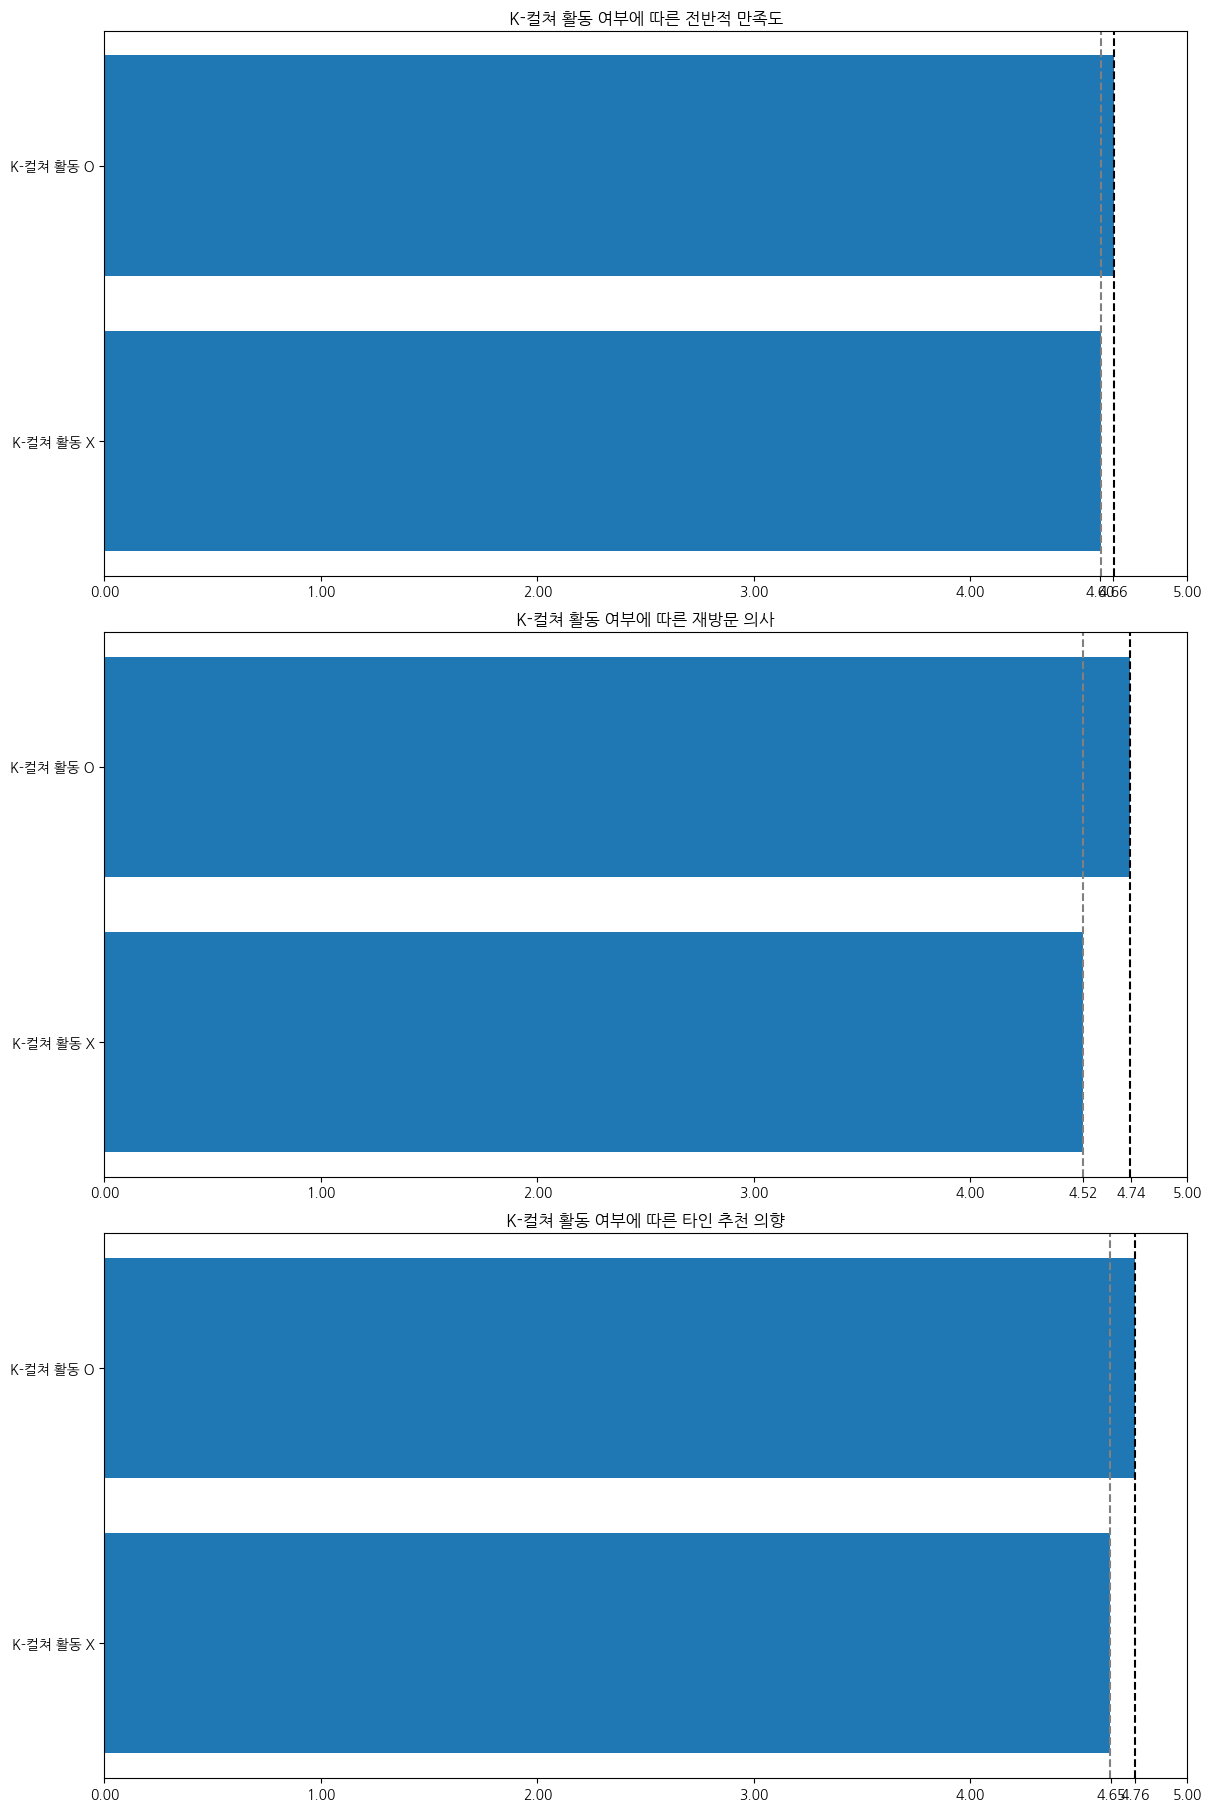

In [10]:
_, axes = plt.subplots(nrows=3, figsize=(12, 18), constrained_layout=True)

axes[0].barh(
    ['K-컬쳐 활동 X', 'K-컬쳐 활동 O'],
    [no_kculture_tour['Q11'].mean(), kculture_tour['Q11'].mean()]
)
axes[0].axvline(no_kculture_tour['Q11'].mean(), color='gray', linestyle='--')
axes[0].axvline(kculture_tour['Q11'].mean(), color='black', linestyle='--')
axes[0].set_title('K-컬쳐 활동 여부에 따른 전반적 만족도')
axes[0].set_xticks([i for i in range(6)] + [np.round(no_kculture_tour['Q11'].mean(), 2), np.round(kculture_tour['Q11'].mean(), 2)])
axes[0].set_xlim(0, 5)

axes[1].barh(
    ['K-컬쳐 활동 X', 'K-컬쳐 활동 O'],
    [no_kculture_tour['Q13'].mean(), kculture_tour['Q13'].mean()]
)
axes[1].axvline(no_kculture_tour['Q13'].mean(), color='gray', linestyle='--')
axes[1].axvline(kculture_tour['Q13'].mean(), color='black', linestyle='--')
axes[1].set_title('K-컬쳐 활동 여부에 따른 재방문 의사')
axes[1].set_xticks([i for i in range(6)] + [np.round(no_kculture_tour['Q13'].mean(), 2), np.round(kculture_tour['Q13'].mean(), 2)])
axes[1].set_xlim(0, 5)

axes[2].barh(
    ['K-컬쳐 활동 X', 'K-컬쳐 활동 O'],
    [no_kculture_tour['Q14'].mean(), kculture_tour['Q14'].mean()]
)
axes[2].axvline(no_kculture_tour['Q14'].mean(), color='gray', linestyle='--')
axes[2].axvline(kculture_tour['Q14'].mean(), color='black', linestyle='--')
axes[2].set_title('K-컬쳐 활동 여부에 따른 타인 추천 의향')
axes[2].set_xticks([i for i in range(6)] + [np.round(no_kculture_tour['Q14'].mean(), 2), np.round(kculture_tour['Q14'].mean(), 2)])
axes[2].set_xlim(0, 5)

plt.show()

In [11]:
# 정규성 검정
test_columns = {
    '전반적 만족도': 'Q11',
    '재방문 의사': 'Q13',
    '타인 추천 의향': 'Q14'
}

for column_name, column in test_columns.items():
    _, sa_p = stats.shapiro(kculture_tour['Q11'].to_numpy())
    _, sb_p = stats.shapiro(no_kculture_tour['Q11'].to_numpy())

    if sa_p < 0.05:
        print(f"K-컬쳐 관광객의 {column_name} 정규성 불만족")
    else:
        print(f"K-컬쳐 관광객의 {column_name} 정규성 만족")

    if sb_p < 0.05:
        print(f"일반 관광객의 {column_name} 정규성 불만족")
    else:
        print(f"일반 관광객의 {column_name} 정규성 만족")

K-컬쳐 관광객의 전반적 만족도 정규성 불만족
일반 관광객의 전반적 만족도 정규성 불만족
K-컬쳐 관광객의 재방문 의사 정규성 불만족
일반 관광객의 재방문 의사 정규성 불만족
K-컬쳐 관광객의 타인 추천 의향 정규성 불만족
일반 관광객의 타인 추천 의향 정규성 불만족


In [12]:
# 정규성 가정 시
for column_name, column in test_columns.items():
    _, levene_p = stats.levene(kculture_tour[column].to_numpy(), no_kculture_tour[column].to_numpy())
    equal_var = False
    if levene_p > 0.05:
        equal_var = True
        print(f"{column_name} 등분산 만족")
    else:
        print(f"{column_name} 등분산 불만족")
    
    _, t_p = stats.ttest_ind(kculture_tour[column].to_numpy(), no_kculture_tour[column].to_numpy(), equal_var=equal_var, alternative='greater')
    if t_p < 0.05:
        print(f">> K-컬쳐 관광객이 그렇지 않은 관광객보다 {column_name} 높음.")
    else:
        print(f">> K-컬쳐 관광객이 그렇지 않은 관광객보다 {column_name} 높지 않음.")
    print()

전반적 만족도 등분산 불만족
>> K-컬쳐 관광객이 그렇지 않은 관광객보다 전반적 만족도 높음.

재방문 의사 등분산 불만족
>> K-컬쳐 관광객이 그렇지 않은 관광객보다 재방문 의사 높음.

타인 추천 의향 등분산 불만족
>> K-컬쳐 관광객이 그렇지 않은 관광객보다 타인 추천 의향 높음.



In [13]:
# 비정규성 가정 시
for column_name, column in test_columns.items():
    _, man_p = stats.mannwhitneyu(kculture_tour[column].to_numpy(), no_kculture_tour[column].to_numpy(), alternative='greater')
    if man_p < 0.05:
        print(f"K-컬쳐 관광객이 그렇지 않은 관광객보다 {column_name} 높음.")
    else:
        print(f"K-컬쳐 관광객이 그렇지 않은 관광객보다 {column_name} 높지 않음.")

K-컬쳐 관광객이 그렇지 않은 관광객보다 전반적 만족도 높음.
K-컬쳐 관광객이 그렇지 않은 관광객보다 재방문 의사 높음.
K-컬쳐 관광객이 그렇지 않은 관광객보다 타인 추천 의향 높음.


---

## 4. 콘텐츠 투어리즘 관광객의 특성 분석

- 문제 정의
    - **콘텐츠 투어리즘 관광객의 특성**을 확인하여 이에 따른 **맞춤 전략**을 구상

In [14]:
active = foreign_cf[(foreign_cf['motive_k-culture'] == True) & (foreign_cf['plan_k-culture'] == True) & (foreign_cf['did_k-culture'] == True)]
potential = foreign_cf[(foreign_cf['motive_k-culture'] == True) & (foreign_cf['did_k-culture'] == False)]

active.shape, potential.shape

((984, 372), (2409, 372))

- 대한민국을 방문한 외국인 관광객으로부터 다음의 **두 집단**을 **정의**
    - 집단 1: K-콘텐츠로 관심을 갖고, 활동을 계획 후 실제로 수행한 관광객 (이상 **‘활동적 관광객’**)
    - 집단 2: K-콘텐츠로 한국에 관심을 가졌으나, K-콘텐츠 활동을 하지 않은 관광객 (이상 **‘잠재적 관광객’**)
<br><br>
- **두 집단의 특성**을 확인하기 위한 분석 **지표 정의**
    - 인구통계학적 지표
    - 관광 계획 단계에서의 정보 수집 경로
    - 관광 시 패키지 상품 구매 여부
    - 여행 동반 인원

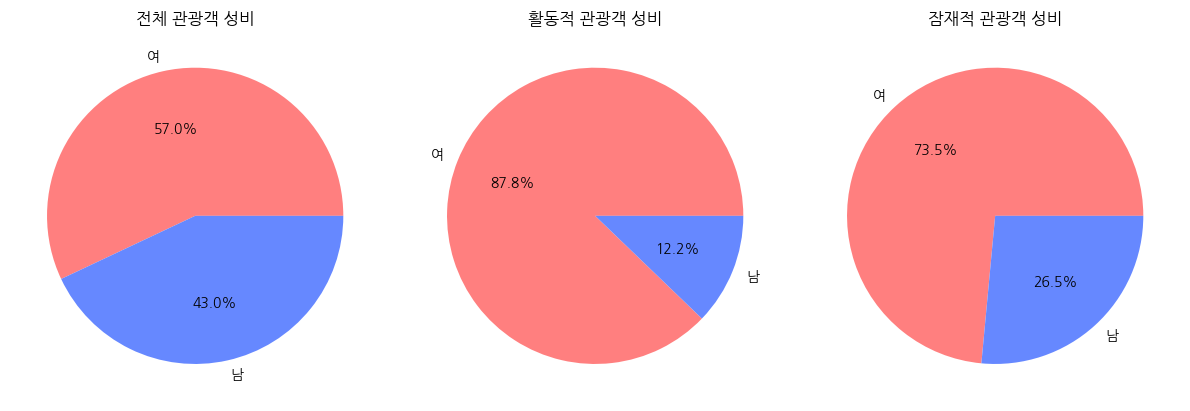

In [15]:
_, axes = plt.subplots(figsize=(12, 4), ncols=3, constrained_layout=True)

axes[0].pie(
    foreign_cf['D_SEX'].map({1: '남', 2: '여'}).value_counts(normalize=True).to_pandas(),
    labels=['여', '남'],
    colors=['#FF7F7F', '#6688FF'],
    autopct='%.1f%%'
)
axes[0].set_title('전체 관광객 성비')

axes[1].pie(
    active['D_SEX'].map({1: '남', 2: '여'}).value_counts(normalize=True).to_pandas(),
    labels=['여', '남'],
    colors=['#FF7F7F', '#6688FF'],
    autopct='%.1f%%'
)
axes[1].set_title('활동적 관광객 성비')

axes[2].pie(
    potential['D_SEX'].map({1: '남', 2: '여'}).value_counts(normalize=True).to_pandas(),
    labels=['여', '남'],
    colors=['#FF7F7F', '#6688FF'],
    autopct='%.1f%%'
)
axes[2].set_title('잠재적 관광객 성비')

plt.show()

- 활동적 관광객, 잠재적 관광객 모두 **여성**의 비율이 압도적임.

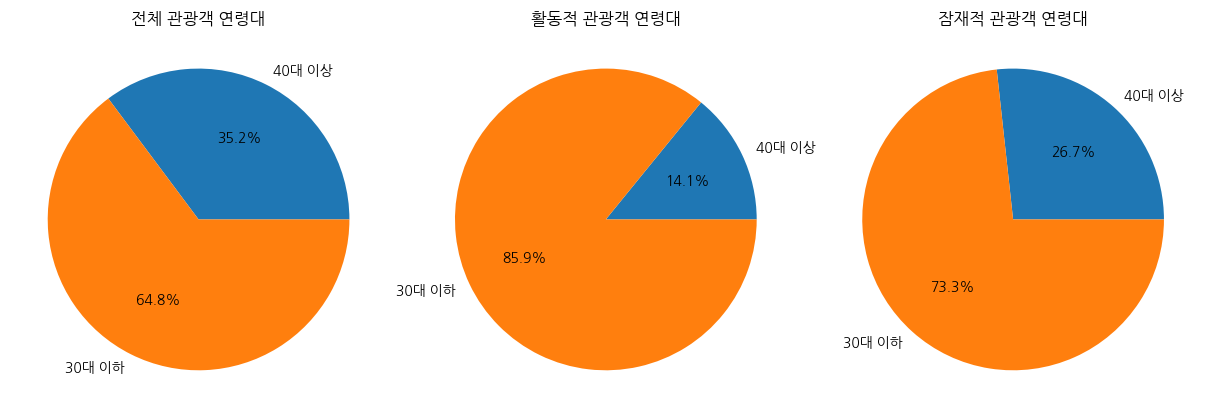

In [16]:
_, axes = plt.subplots(figsize=(12, 4), ncols=3, constrained_layout=True)

axes[0].pie(
    foreign_cf['D_AGE'].isin([1, 2, 3]).value_counts().sort_index().to_pandas(),
    labels=['40대 이상', '30대 이하'],
    autopct='%.1f%%'
)
axes[0].set_title('전체 관광객 연령대')

axes[1].pie(
    active['D_AGE'].isin([1, 2, 3]).value_counts().sort_index().to_pandas(),
    labels=['40대 이상', '30대 이하'],
    autopct='%.1f%%'
)
axes[1].set_title('활동적 관광객 연령대')

axes[2].pie(
    potential['D_AGE'].isin([1, 2, 3]).value_counts().sort_index().to_pandas(),
    labels=['40대 이상', '30대 이하'],
    autopct='%.1f%%'
)
axes[2].set_title('잠재적 관광객 연령대')

plt.show()

- 활동적 관광객, 잠재적 관광객 모두 **30대 이하**의 비율이 유의미하게 높음.

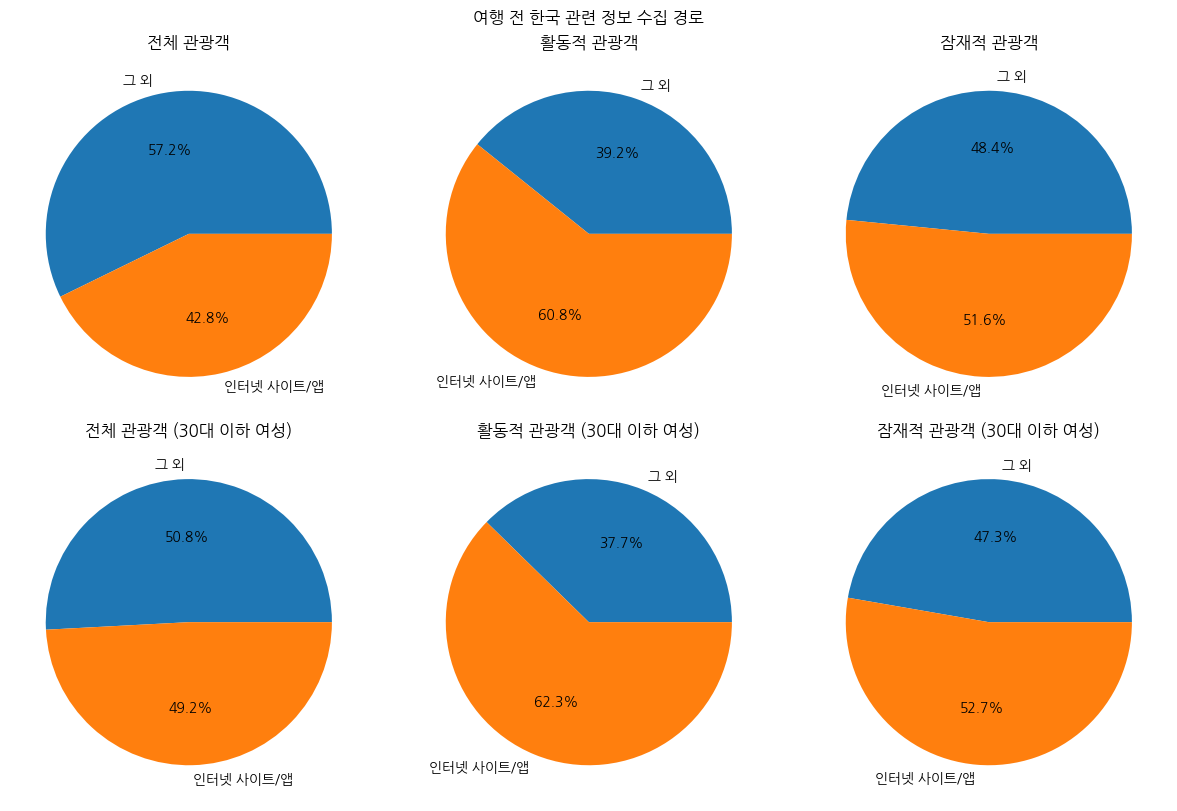

In [17]:
foreign_cf['Q4a'] = foreign_cf['Q4a1'].fillna(0)
active['Q4a'] = active['Q4a1'].fillna(0)
potential['Q4a'] = potential['Q4a1'].fillna(0)

_, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=2, constrained_layout=True)

axes[0][0].pie(
    (foreign_cf['Q4a'] == 1).value_counts().sort_index().to_pandas(),
    labels=['그 외', '인터넷 사이트/앱'],
    autopct='%.1f%%'
)
axes[0][0].set_title('전체 관광객')

axes[0][1].pie(
    (active['Q4a'] == 1).value_counts().sort_index().to_pandas(),
    labels=['그 외', '인터넷 사이트/앱'],
    autopct='%.1f%%'
)
axes[0][1].set_title('활동적 관광객')

axes[0][2].pie(
    (potential['Q4a'] == 1).value_counts().sort_index().to_pandas(),
    labels=['그 외', '인터넷 사이트/앱'],
    autopct='%.1f%%'
)
axes[0][2].set_title('잠재적 관광객')

axes[1][0].pie(
    (foreign_cf[(foreign_cf['D_SEX'] == 2) & (foreign_cf['D_AGE'].isin([1, 2, 3]))]['Q4a'] == 1).value_counts().sort_index().to_pandas(),
    labels=['그 외', '인터넷 사이트/앱'],
    autopct='%.1f%%'
)
axes[1][0].set_title('전체 관광객 (30대 이하 여성)')

axes[1][1].pie(
    (active[(active['D_SEX'] == 2) & (active['D_AGE'].isin([1, 2, 3]))]['Q4a'] == 1).value_counts().sort_index().to_pandas(),
    labels=['그 외', '인터넷 사이트/앱'],
    autopct='%.1f%%'
)
axes[1][1].set_title('활동적 관광객 (30대 이하 여성)')

axes[1][2].pie(
    (potential[(potential['D_SEX'] == 2) & (potential['D_AGE'].isin([1, 2, 3]))]['Q4a'] == 1).value_counts().sort_index().to_pandas(),
    labels=['그 외', '인터넷 사이트/앱'],
    autopct='%.1f%%'
)
axes[1][2].set_title('잠재적 관광객 (30대 이하 여성)')

plt.suptitle('여행 전 한국 관련 정보 수집 경로')
plt.show()

- 활동적 관광객은 **인터넷 사이트/앱**을 이용해 정보 수집한 비율이 높음.

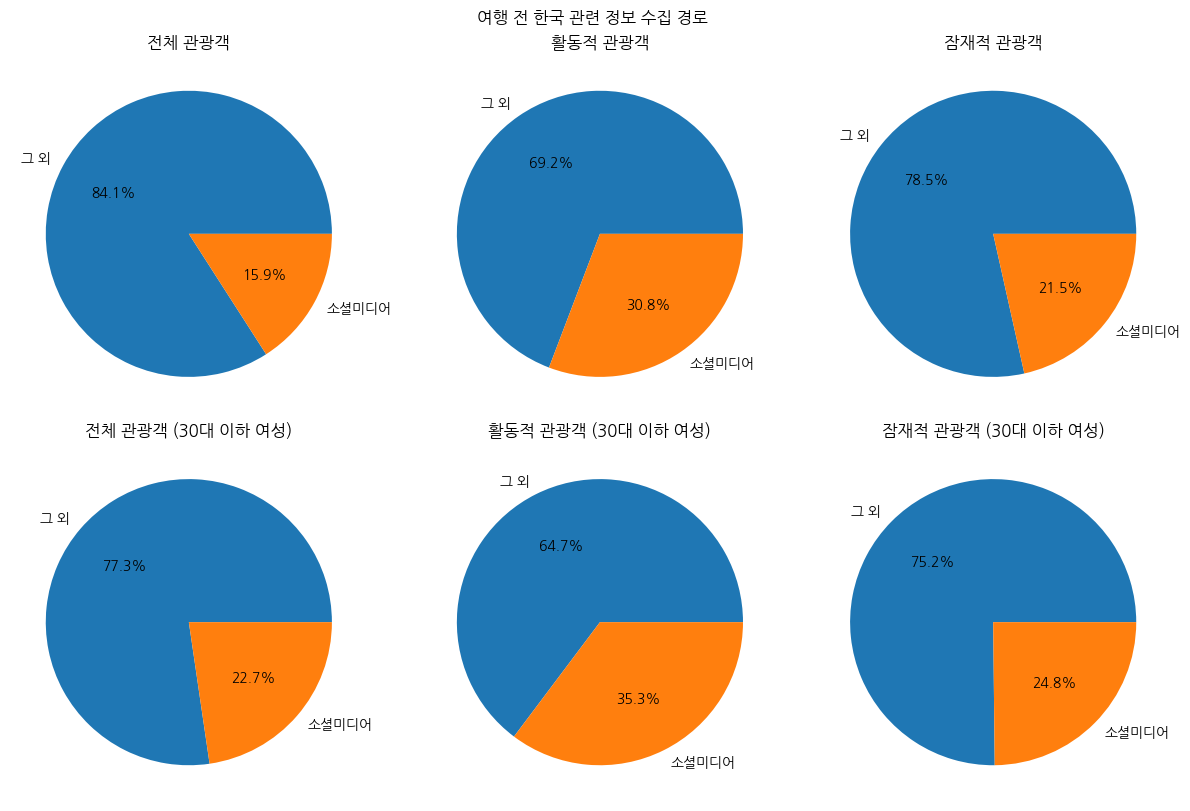

In [18]:
foreign_cf['Q4_1a'] = foreign_cf['Q4_1a1'].fillna(0)
active['Q4_1a'] = active['Q4_1a1'].fillna(0)
potential['Q4_1a'] = potential['Q4_1a1'].fillna(0)

_, axes = plt.subplots(figsize=(12, 8), ncols=3, nrows=2, constrained_layout=True)

axes[0][0].pie(
    (foreign_cf['Q4_1a'] == 5).value_counts().sort_index().to_pandas(),
    labels=['그 외', '소셜미디어'],
    autopct='%.1f%%'
)
axes[0][0].set_title('전체 관광객')

axes[0][1].pie(
    (active['Q4_1a'] == 5).value_counts().sort_index().to_pandas(),
    labels=['그 외', '소셜미디어'],
    autopct='%.1f%%'
)
axes[0][1].set_title('활동적 관광객')

axes[0][2].pie(
    (potential['Q4_1a'] == 5).value_counts().sort_index().to_pandas(),
    labels=['그 외', '소셜미디어'],
    autopct='%.1f%%'
)
axes[0][2].set_title('잠재적 관광객')

axes[1][0].pie(
    (foreign_cf[(foreign_cf['D_SEX'] == 2) & (foreign_cf['D_AGE'].isin([1, 2, 3]))]['Q4_1a'] == 5).value_counts().sort_index().to_pandas(),
    labels=['그 외', '소셜미디어'],
    autopct='%.1f%%'
)
axes[1][0].set_title('전체 관광객 (30대 이하 여성)')

axes[1][1].pie(
    (active[(active['D_SEX'] == 2) & (active['D_AGE'].isin([1, 2, 3]))]['Q4_1a'] == 5).value_counts().sort_index().to_pandas(),
    labels=['그 외', '소셜미디어'],
    autopct='%.1f%%'
)
axes[1][1].set_title('활동적 관광객 (30대 이하 여성)')

axes[1][2].pie(
    (potential[(potential['D_SEX'] == 2) & (potential['D_AGE'].isin([1, 2, 3]))]['Q4_1a'] == 5).value_counts().sort_index().to_pandas(),
    labels=['그 외', '소셜미디어'],
    autopct='%.1f%%'
)
axes[1][2].set_title('잠재적 관광객 (30대 이하 여성)')

plt.suptitle('여행 전 한국 관련 정보 수집 경로')
plt.show()

- 활동적 관광객들은 **소셜미디어**를 이용해 정보 수집한 비율이 높음.

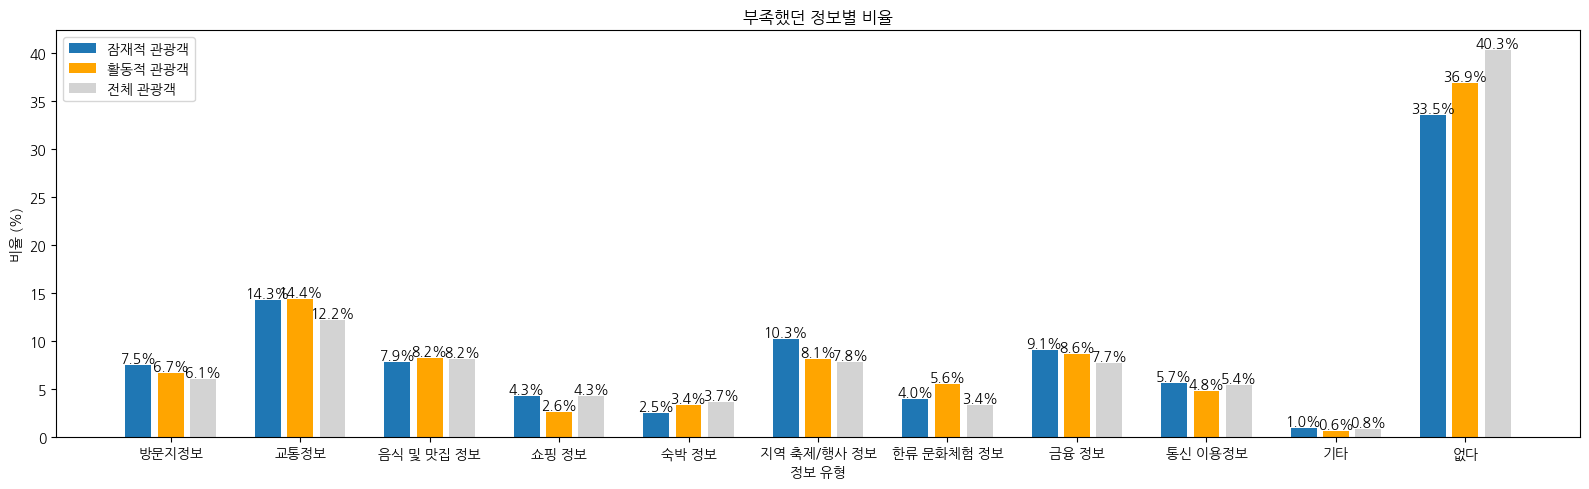

In [19]:
# col 지정
col = 'Q4_2a1'

# x축 위치 설정
x = np.arange(0,11)  # 각 항목의 위치
width = 0.20  # 막대 너비
gap = 0.05  # 막대 사이의 간격

fig, ax = plt.subplots(figsize=(16,5))

# 데이터 막대
bars1 = ax.bar(x - (width + gap), potential.to_pandas()[col].fillna(11).value_counts(normalize=True).sort_index(), width, label='잠재적 관광객')
bars2 = ax.bar(x, active.to_pandas()[col].fillna(11).value_counts(normalize=True).sort_index(), width, label='활동적 관광객', color='orange')
bars3 = ax.bar(x + (width + gap), foreign_cf.to_pandas()[col].fillna(11).value_counts(normalize=True).sort_index(), width, label='전체 관광객', color='lightgray')

# 막대 레이블
for bars in [bars1, bars2, bars3]:
    for rect in bars:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height, f'{height*100:.1f}%', ha='center', va='bottom')
    
# x, y축 레이블 및 제목 설정
ax.set_xticks(x)
ax.set_xticklabels(
    ['방문지정보','교통정보','음식 및 맛집 정보','쇼핑 정보',
     '숙박 정보','지역 축제/행사 정보','한류 문화체험 정보','금융 정보',
     '통신 이용정보','기타', '없다']
)
ax.set_xlabel('정보 유형')

ax.set_yticks(np.arange(0,45,5)/100)
ax.set_yticklabels([r for r in range(0,45,5)])
ax.set_ylabel('비율 (%)')

ax.set_title('부족했던 정보별 비율')
ax.legend(loc='upper left')


# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.show()

- 관광객들은 **교통정보, 지역 축제/행사 정보, 금융 정보** 등을 부족하다고 느꼈음.

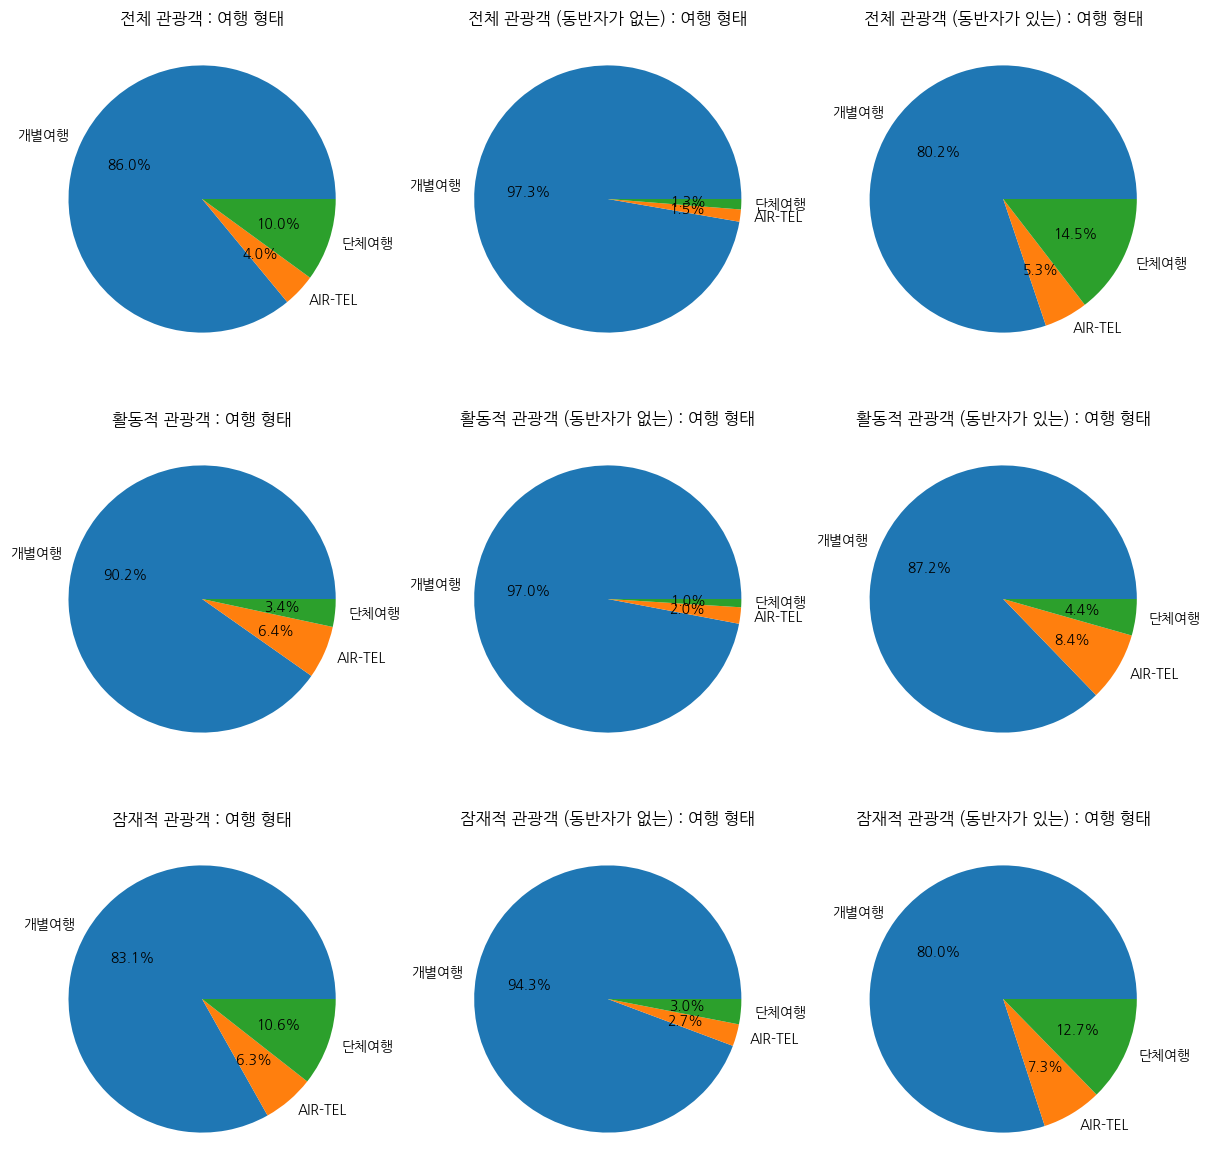

In [20]:
_, axes = plt.subplots(figsize=(12, 12), nrows=3, ncols=3, constrained_layout=True)

axes[0][0].pie(
    foreign_cf['D_GUB'].value_counts().sort_index().to_pandas(),
    labels=['개별여행', 'AIR-TEL', '단체여행'],
    autopct='%.1f%%'
)
axes[0][0].set_title('전체 관광객 : 여행 형태')

axes[0][1].pie(
    foreign_cf[foreign_cf['Q7A'] == 1]['D_GUB'].value_counts().sort_index().to_pandas(),
    labels=['개별여행', 'AIR-TEL', '단체여행'],
    autopct='%.1f%%'
)
axes[0][1].set_title('전체 관광객 (동반자가 없는) : 여행 형태')

axes[0][2].pie(
    foreign_cf[foreign_cf['Q7A'] == 2]['D_GUB'].value_counts().sort_index().to_pandas(),
    labels=['개별여행', 'AIR-TEL', '단체여행'],
    autopct='%.1f%%'
)
axes[0][2].set_title('전체 관광객 (동반자가 있는) : 여행 형태')

axes[1][0].pie(
    active['D_GUB'].value_counts().sort_index().to_pandas(),
    labels=['개별여행', 'AIR-TEL', '단체여행'],
    autopct='%.1f%%'
)
axes[1][0].set_title('활동적 관광객 : 여행 형태')

axes[1][1].pie(
    active[active['Q7A'] == 1]['D_GUB'].value_counts().sort_index().to_pandas(),
    labels=['개별여행', 'AIR-TEL', '단체여행'],
    autopct='%.1f%%'
)
axes[1][1].set_title('활동적 관광객 (동반자가 없는) : 여행 형태')

axes[1][2].pie(
    active[active['Q7A'] == 2]['D_GUB'].value_counts().sort_index().to_pandas(),
    labels=['개별여행', 'AIR-TEL', '단체여행'],
    autopct='%.1f%%'
)
axes[1][2].set_title('활동적 관광객 (동반자가 있는) : 여행 형태')

axes[2][0].pie(
    potential['D_GUB'].value_counts().sort_index().to_pandas(),
    labels=['개별여행', 'AIR-TEL', '단체여행'],
    autopct='%.1f%%'
)
axes[2][0].set_title('잠재적 관광객 : 여행 형태')

axes[2][1].pie(
    potential[potential['Q7A'] == 1]['D_GUB'].value_counts().sort_index().to_pandas(),
    labels=['개별여행', 'AIR-TEL', '단체여행'],
    autopct='%.1f%%'
)
axes[2][1].set_title('잠재적 관광객 (동반자가 없는) : 여행 형태')

axes[2][2].pie(
    potential[potential['Q7A'] == 2]['D_GUB'].value_counts().sort_index().to_pandas(),
    labels=['개별여행', 'AIR-TEL', '단체여행'],
    autopct='%.1f%%'
)
axes[2][2].set_title('잠재적 관광객 (동반자가 있는) : 여행 형태')

plt.show()

- 활동적 관광객들은 동반자가 있더라도 패키지 상품을 이용하지 않고 **개별여행**을 하는 경향이 짙음.
- 잠재적 관광객들은 비교적 **패키지 여행** 많음.

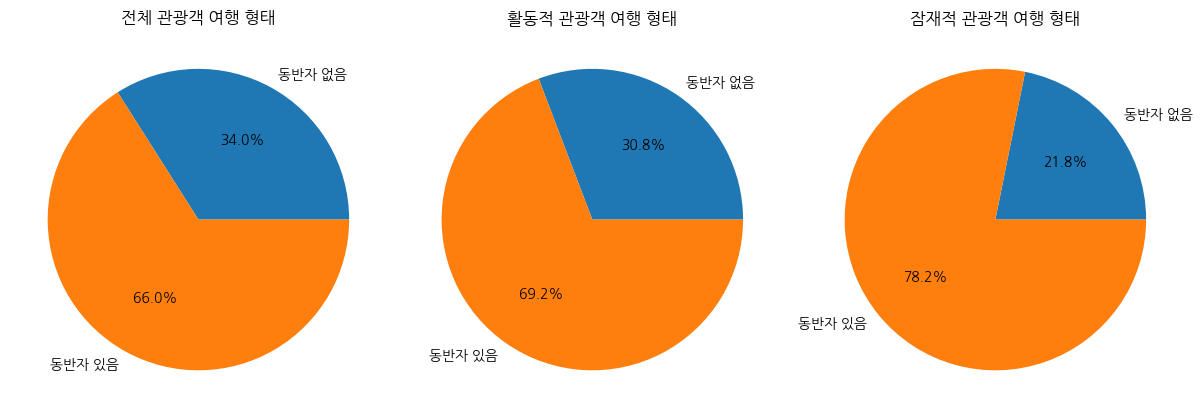

In [21]:
_, axes = plt.subplots(figsize=(12, 4), ncols=3, constrained_layout=True)

axes[0].pie(
    foreign_cf['Q7A'].value_counts().sort_index().to_pandas(),
    labels=['동반자 없음', '동반자 있음'],
    autopct='%.1f%%'
)
axes[0].set_title('전체 관광객 여행 형태')

axes[1].pie(
    active['Q7A'].value_counts().sort_index().to_pandas(),
    labels=['동반자 없음', '동반자 있음'],
    autopct='%.1f%%'
)
axes[1].set_title('활동적 관광객 여행 형태')

axes[2].pie(
    potential['Q7A'].value_counts().sort_index().to_pandas(),
    labels=['동반자 없음', '동반자 있음'],
    autopct='%.1f%%'
)
axes[2].set_title('잠재적 관광객 여행 형태')

plt.show()

- 활동적 관광객들은 잠재적 관광객들에 비해 **혼자** 여행하는 경우 많음.
- 잠재적 관광객들은 활동적 관광객들에 비해 **동반자 있는** 경우 많음.

> **결론: 잠재적 관광객과 활동적 관광객에서 다음의 관광 행태를 파악하였음.**
> - 잠재적 관광객, 활동적 관광객 모두 **30대 이하, 여성**이 절대 다수를 차지함.
> - 잠재적 관광객, 활동적 관광객 모두 **인터넷** 이용한 정보 수집 많음, 그 중에서도 **소셜 미디어**를 통한 정보 수집 많음.
> - 잠재적 관광객은 주로 패키지 이용하지 않고 **개별여행**을 하는 성향이 강함.
> - 활동적 관광객은 잠재적 관광객에 비해 비교적 **동반자** 있는 경우 많음, 비교적 **패키지** 여행 많음.
> - 관광객들은 **교통정보, 지역 축제/행사 정보, 금융 정보** 등을 부족하다고 느꼈음.

---

## 5. 시사점 및 정책 활용 아이디어 제시

- 마케팅 타겟 선정
    - **30대 이하, 여성**
    - 인터넷 마케팅, 특히 **SNS**를 통한 마케팅 유용
<br><br>
- 신규 비즈니스 **'여행 친구 매칭 서비스'** 고안
    - K-콘텐츠에 흥미를 느끼는 외국인 관광객에게 **관심사 기반**의 내국인을 연결함.
    - 같은 콘텐츠를 좋아하는 친구를 연결해주어 **특별한 관광 경험**을 제공함.
    - 관광객들이 찾기 어려웠던 정보에 대해 내국인의 도움을 받을 수 있음.
    - 잠재적 관광객들도 내국인 친구와의 유대감으로써 콘텐츠 투어리즘으로 이끌어 나갈 수 있음.
<br><br>
- 관광객들의 성향과 수요를 반영한 맞춤형 상품 기획
    - 개별여행을 선호하는 경향이 짙으므로, **자유도가 높은** 콘텐츠 연계 관광 상품 기획을 제안함.
    - K-콘텐츠 모티브의 **팝업스토어**와 같은 **관객 참여형 즐길거리나 축제**의 기획을 제안함.